# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb




asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx']=asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly']=asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx']=asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
#asl.df['df_std']= asl.df['speaker'].map(df_std['left-x'])

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

#asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x']) # already done above
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-lx']= (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']

asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['norm-ly']= (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']

asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-rx']= (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']

asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])
asl.df['norm-ry']= (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

asl.df['polar-rr']=  np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2) 
asl.df['polar-rtheta']=np.arctan2(asl.df['grnd-rx'],asl.df['grnd-ry'])

asl.df['polar-lr']=  np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta']=np.arctan2(asl.df['grnd-lx'],asl.df['grnd-ly'])


features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx']=asl.df['right-x'].diff().fillna(value=0)
asl.df['delta-ry']=asl.df['right-y'].diff().fillna(value=0)
asl.df['delta-lx']=asl.df['left-x'].diff().fillna(value=0)
asl.df['delta-ly']=asl.df['left-y'].diff().fillna(value=0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

#distance from left to right hand, uses the normalized values
asl.df['dist-norm-left-right']=np.sqrt((asl.df['norm-rx'] - asl.df['norm-lx'])**2+(asl.df['norm-ry'] - asl.df['norm-ly'])**2)
#change in dist from left to right hand
asl.df['delta-dist-norm-left-right']=asl.df['dist-norm-left-right'].diff().fillna(value=0)

features_hand_dist=['dist-norm-left-right','delta-dist-norm-left-right']

#deltas of the normalized hand positions
asl.df['delta-norm-rx'] = asl.df['norm-rx'].diff().fillna(value=0)
asl.df['delta-norm-ry'] = asl.df['norm-ry'].diff().fillna(value=0)
asl.df['delta-norm-lx'] = asl.df['norm-lx'].diff().fillna(value=0)
asl.df['delta-norm-ly'] = asl.df['norm-ly'].diff().fillna(value=0)

features_delta_norm_hand_pos=['delta-norm-rx', 'delta-norm-ry', 'delta-norm-lx', 'delta-norm-ly']

#normalized polar coords:
asl.df['norm-polar-rr'] = (asl.df['polar-rr'] - min(asl.df['polar-rr']))/(max(asl.df['polar-rr'])-min(asl.df['polar-rr']))
asl.df['norm-rtheta'] = (asl.df['polar-rtheta'] - min(asl.df['polar-rtheta']))/(max(asl.df['polar-rtheta'])-min(asl.df['polar-rtheta']))
asl.df['norm-polar-lr'] = (asl.df['polar-lr'] - min(asl.df['polar-lr']))/(max(asl.df['polar-lr'])-min(asl.df['polar-lr']))
asl.df['norm-polar-ltheta'] = (asl.df['polar-ltheta'] - min(asl.df['polar-ltheta']))/(max(asl.df['polar-ltheta'])-min(asl.df['polar-rr']))

#delta of norm polar coords:
asl.df['delta-norm-polar-rr'] = asl.df['norm-polar-rr'].diff().fillna(value=0)
asl.df['delta-norm-rtheta'] = asl.df['norm-rtheta'].diff().fillna(value=0)
asl.df['delta-norm-polar-lr'] = asl.df['norm-polar-lr'].diff().fillna(value=0)
asl.df['delta-norm-polar-ltheta'] = asl.df['norm-polar-ltheta'].diff().fillna(value=0)

features_norm_polar_coords=['norm-polar-rr','norm-rtheta','norm-polar-lr','norm-polar-ltheta','delta-norm-polar-rr','delta-norm-rtheta','delta-norm-polar-lr','delta-norm-polar-ltheta']

features_custom=features_hand_dist+features_delta_norm_hand_pos+features_norm_polar_coords
asl.df.tail()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
125   52        148     181      171      156     162      60  woman-1   
      53        148     181      172      165     162      60  woman-1   
      54        148     181      175      173     162      60  woman-1   
      55        148     181      175      173     162      60  woman-1   
      56        148     181      175      173     162      60  woman-1   

             grnd-ry  grnd-rx  grnd-ly           ...             \
video frame                                      ...              
125   52          96        9      121           ...              
      53         105       10      121           ...              
      54         113       13      121           ...              
      55         113       13      121           ...              
      56         113       13      121           ...              

             delta-norm-lx  delta-norm-ly  norm-polar-rr  norm-rtheta  \
video frame                                                             
125   52               0.0            0.0       0.501696     0.492394   
      53               0.0            0.0       0.550231     0.492640   
      54               0.0            0.0       0.594562     0.495902   
      55               0.0            0.0       0.594562     0.495902   
      56               0.0            0.0       0.594562     0.495902   

             norm-polar-lr  norm-polar-ltheta  delta-norm-polar-rr  \
video frame                                                          
125   52          0.571161           -0.11469             0.048993   
      53          0.571161           -0.11469             0.048534   
      54          0.571161           -0.11469             0.044332   
      55          0.571161           -0.11469             0.000000   
      56          0.571161           -0.11469             0.000000   

             delta-norm-rtheta  delta-norm-polar-lr  delta-norm-polar-ltheta  
video frame                                                                   
125   52              0.002197                  0.0                      0.0  
      53              0.000246                  0.0                      0.0  
      54              0.003262                  0.0                      0.0  
      55              0.000000                  0.0                      0.0  
      56              0.000000                  0.0                      0.0  

[5 rows x 45 columns]

In [15]:
#list of the features 
features_ground
features_norm
features_polar
features_delta
features_custom=features_hand_dist+features_delta_norm_hand_pos+features_norm_polar_coords
features_best=features_norm+features_custom

**Question 1:**  What custom features did you choose for the features_custom set and why?

1. Normalized distance from right to left hand and the delta of normalized distance between hands. The distance between hands may be an indicator, and the normalized value is preferred to assist in eliminating differences between speakers. in addition the speed/direction of moving together or apart may be an indicator.
3. Delta of the normalized hand position. The change in position should be based on normalized positions
4. Normalized Polar co-ordinates, again, to assist w/speaker independance 
5. The related delta of the normalized Polar coords, as change in position may be helpful

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [16]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.026s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743319


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [19]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028621


In [20]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [   0.58333258   87.91666611   12.75000001  108.49999882]
variance =  [  39.4105671    18.74389523    9.85499958  144.41752618]

hidden state #1
mean =  [ -4.93681705  64.73171915   1.62598519  84.91459657]
variance =  [  6.1617479   28.36616959   5.47102461  13.11696032]

hidden state #2
mean =  [  -6.37712306   51.09867416    3.64009161  104.46268173]
variance =  [  10.28220014   12.44316166   27.33390004  106.91029392]

hidden state #3
mean =  [ -9.23835975  55.307463     6.92298661  71.30538347]
variance =  [ 16.30887738  45.97071639   3.76856896  15.98215464]

logL = -565.1243334331189


In [21]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.47581504 -0.25534057 -0.32768595 -1.7243523 ]
variance =  [ 0.042362    0.00442977  0.00152113  0.0066983 ]

hidden state #1
mean =  [ 0.49163141 -0.34766944 -0.19907141 -0.31200148]
variance =  [ 0.02973162  0.00401851  0.00934483  0.2921408 ]

hidden state #2
mean =  [ 0.9894402  -0.16006052 -1.31412901 -1.55560526]
variance =  [ 0.10711401  0.00555855  0.03518414  0.09325342]

hidden state #3
mean =  [ 0.494375    0.05588065  0.10128493 -0.81554085]
variance =  [ 0.05344461  0.02787475  0.01792018  0.07558914]

logL = 85.72111948347856


In [22]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_hand_dist) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.70326771  0.00393284]
variance =  [ 0.05846787  0.12020401]

hidden state #1
mean =  [ 1.67115958  0.08294104]
variance =  [ 0.01077021  0.05687346]

hidden state #2
mean =  [ 2.79182418  0.08961714]
variance =  [ 0.09747049  0.09519826]

hidden state #3
mean =  [ 1.01845213  0.02174606]
variance =  [ 0.01126724  0.01299081]

logL = 17.011107817911498


In [23]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_delta_norm_hand_pos) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [-0.0480411   0.02301395  0.33806905 -0.28418428]
variance =  [ 0.00750924  0.00480335  0.00794685  0.05676355]

hidden state #1
mean =  [-0.05712648  0.09690884  0.02703457  0.09635826]
variance =  [ 0.08911966  0.01143685  0.03057315  0.0131411 ]

hidden state #2
mean =  [  6.59754455e-11   4.32756245e-03   9.77124970e-22   2.51896024e-21]
variance =  [ 0.00050009  0.00085585  0.00050009  0.00050009]

hidden state #3
mean =  [ 0.15715851 -0.00802616 -0.07882145 -0.30428311]
variance =  [ 0.02499005  0.00381481  0.02226397  0.01054853]

logL = 257.9532970856098


In [24]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_norm_polar_coords) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [  3.30979923e-01   4.64138086e-01   3.51761236e-01  -2.08758453e-01
   7.52665677e-03   3.16500921e-04  -1.01021772e-03   2.40865789e-03]
variance =  [ 0.00142054  0.00063018  0.00138223  0.00091643  0.00073207  0.00061309
  0.00103423  0.00096823]

hidden state #1
mean =  [ 0.45726054  0.47821239  0.49519442 -0.27765755 -0.00885866  0.00393144
 -0.01907447 -0.00223042]
variance =  [ 0.00142803  0.00096031  0.00606245  0.0013628   0.00120702  0.00090085
  0.00244372  0.00109839]

hidden state #2
mean =  [ 0.25693787  0.45443133  0.48646859 -0.2187799   0.00718578  0.00283913
 -0.0502764  -0.00990431]
variance =  [ 0.00178148  0.00174985  0.00454189  0.00304516  0.00168599  0.0016301
  0.00291674  0.00189159]

hidden state #3
mean =  [ 0.28427069  0.44999872  0.27170853 -0.26126657  0.01053902 -0.00080419
 -0.00609619 -0.00281184]
variance =  [ 0.00216161  0.00081977  0.00180867  0.00091722  0.00112796  0.0008

In [25]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.68894685 -0.06726488  0.04545047  0.02671352  0.04150469 -0.43023168
  0.25772443  0.44983789  0.45341639 -0.24243443  0.00438785  0.00264511
 -0.07385162 -0.00940697]
variance =  [ 0.06099841  0.14440328  0.01315092  0.00229277  0.04798564  0.00710977
  0.00214024  0.00206358  0.00662637  0.00240703  0.00197695  0.00199185
  0.00206876  0.00243771]

hidden state #1
mean =  [  2.70040186e+00   1.36252009e-01   1.19035544e-01  -2.12498531e-02
  -5.49894403e-03  -7.79920592e-02   4.57260544e-01   4.78212389e-01
   4.95194423e-01  -2.77657546e-01  -8.85866356e-03   3.93144328e-03
  -1.90744719e-02  -2.23041942e-03]
variance =  [ 0.18128913  0.11118816  0.06340054  0.00447343  0.03237197  0.03364657
  0.00142803  0.00096031  0.00606245  0.0013628   0.00120702  0.00090085
  0.00244372  0.00109839]

hidden state #2
mean =  [  1.66934760e+00   3.93829880e-02  -5.16630049e-02   4.85017537e-02
   2.99923837e-02  -1

In [26]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_norm+features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [  3.96427827e-01  -1.89866022e-01  -2.78868852e-01  -1.67283647e+00
   1.66934706e+00   3.93872892e-02  -5.16604607e-02   4.85022802e-02
   2.99920823e-02  -1.60109936e-02   2.85946693e-01   4.49788134e-01
   2.66464708e-01  -2.61850781e-01   1.08919296e-02  -1.07356630e-03
  -2.45106441e-03  -4.23095236e-03]
variance =  [ 0.07442649  0.02997019  0.01666081  0.01991189  0.01155139  0.03468456
  0.04944711  0.00971997  0.00701592  0.02088026  0.00223604  0.00086659
  0.00141099  0.00096408  0.00119123  0.00086531  0.00140809  0.00084166]

hidden state #1
mean =  [  5.52775770e-01   5.85133921e-02   1.12964413e-01  -7.76093053e-01
   9.76746406e-01   4.40507571e-02   3.57790738e-03   4.06647112e-02
  -2.01092386e-02  -4.42867042e-03   3.31092050e-01   4.64138718e-01
   3.51638001e-01  -2.08757778e-01   7.52906570e-03   3.38985208e-04
  -6.93103104e-04   2.54923467e-03]
variance =  [ 0.02227333  0.02484758  0.01

In [27]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_norm+features_delta_norm_hand_pos+features_norm_polar_coords) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.9894402  -0.16006052 -1.31412901 -1.55560526  0.11903554 -0.02124985
 -0.00549894 -0.07799206  0.45726054  0.47821239  0.49519442 -0.27765755
 -0.00885866  0.00393144 -0.01907447 -0.00223042]
variance =  [ 0.10711401  0.00555855  0.03518414  0.09325342  0.06340054  0.00447343
  0.03237197  0.03364657  0.00142803  0.00096031  0.00606245  0.0013628
  0.00120702  0.00090085  0.00244372  0.00109839]

hidden state #1
mean =  [  4.79037344e-01   7.91367367e-02   9.79743592e-02  -8.62146688e-01
  -2.61161494e-02   5.73367891e-02   2.71901101e-03   2.15305168e-02
   3.36697578e-01   4.61142063e-01   3.45034007e-01  -2.17819152e-01
   1.15537939e-02  -3.72086568e-04   3.99250687e-03   6.77476387e-05]
variance =  [ 0.05608837  0.02488282  0.01968713  0.05893709  0.01851001  0.0076717
  0.02490391  0.01636512  0.00148742  0.00065105  0.00123304  0.0015544
  0.00085338  0.00058095  0.0009923   0.00096877]

hidden stat

In [28]:
my_testword = 'FUTURE1'
model, logL = train_a_word(my_testword, 4, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for FUTURE1 is 4
hidden state #0
mean =  [ -17.33333333   28.33333333  -18.33333333  124.        ]
variance =  [ 2.89222222  0.22555556  2.89222222  0.67      ]

hidden state #1
mean =  [ -28.33333333   35.66666667   24.66666667  176.33333333]
variance =  [ 0.22555556  0.89222222  0.22555556  0.22555556]

hidden state #2
mean =  [ -24.66666667   27.33333333   28.33333333  174.66666667]
variance =  [ 1.55888889  0.22555556  0.22555556  0.89222222]

hidden state #3
mean =  [ -20.   34.  -22.  125.]
variance =  [ 0.01  0.01  0.01  0.01]

logL = -38.19119712135632


In [29]:
my_testword = 'FUTURE1'
model, logL = train_a_word(my_testword, 4, features_norm+features_delta_norm_hand_pos+features_norm_polar_coords) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for FUTURE1 is 4
hidden state #0
mean =  [-0.45662122 -1.06014359 -0.42330008  0.48136381 -0.00881745 -0.02732124
 -0.03299366  0.00458777  0.2056612   0.35982762  0.90954941 -0.29961143
 -0.010471   -0.0030763  -0.00169276 -0.00149803]
variance =  [ 0.00858618  0.00447737  0.00662576  0.00227705  0.01231806  0.00285546
  0.0114639   0.00303476  0.00223105  0.00170947  0.00169562  0.00172922
  0.00195986  0.00167683  0.00172709  0.00173072]

hidden state #1
mean =  [ -5.28283580e-01  -7.02051402e-01  -2.35331659e+00   2.24553767e-01
  -1.34315737e-01  -2.52212462e-02  -1.94948102e-01   3.46920779e-02
   1.96286884e-01   3.88278656e-01   6.02232933e-01  -7.35164870e-02
   4.76159305e-04  -9.44452806e-03   8.95608707e-03   1.54666406e-02]
variance =  [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01]

hidden state #2
mean =  [-0.42754626 -0.84076828 -2.09338593  0.17251577  0.03357946 -0.06305303
  0.194947

In [30]:
my_testword = 'FUTURE1'
model, logL = train_a_word(my_testword, 4, features_norm+features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for FUTURE1 is 4
hidden state #0
mean =  [ -4.56621224e-01  -1.06014359e+00  -4.23300079e-01   4.81363812e-01
   1.54200037e+00   2.95729979e-02  -8.81744771e-03  -2.73212398e-02
  -3.29936642e-02   4.58776819e-03   2.05661200e-01   3.59827620e-01
   9.09549414e-01  -2.99611432e-01  -1.04710035e-02  -3.07629647e-03
  -1.69275994e-03  -1.49803443e-03]
variance =  [ 0.00858618  0.00447737  0.00662576  0.00227705  0.00647859  0.00399676
  0.01231806  0.00285546  0.0114639   0.00303476  0.00223105  0.00170947
  0.00169562  0.00172922  0.00195986  0.00167683  0.00172709  0.00173072]

hidden state #1
mean =  [-0.19249424 -0.85337888 -2.15836849  0.22455377  2.24200811  0.427276
  0.26863147 -0.02522125 -0.1949481   0.03469208  0.15511124  0.39492573
  0.5992832  -0.08981874 -0.01557265  0.01468697  0.00855339  0.01571052]
variance =  [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01]

hidden state #

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [31]:
%matplotlib inline

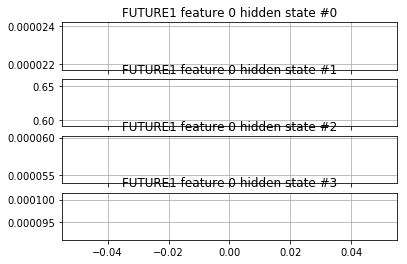

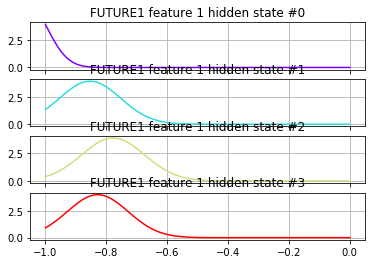

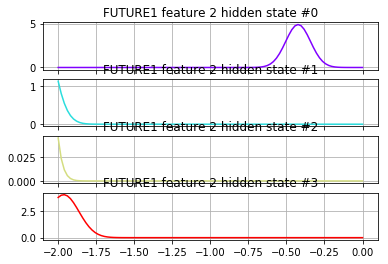

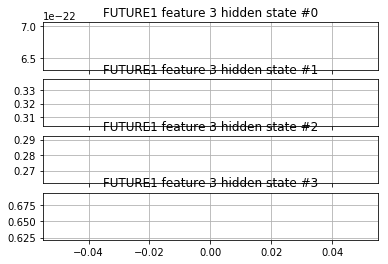

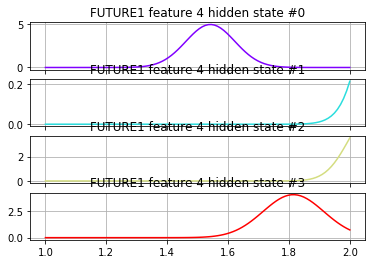

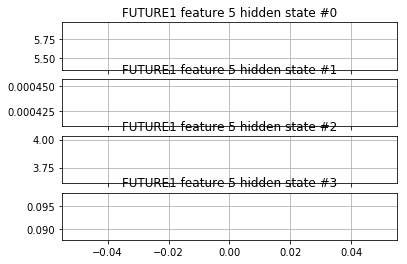

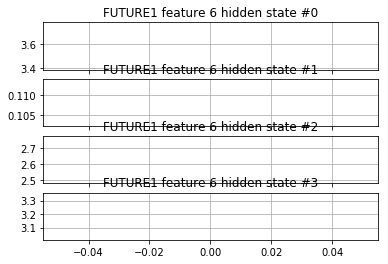

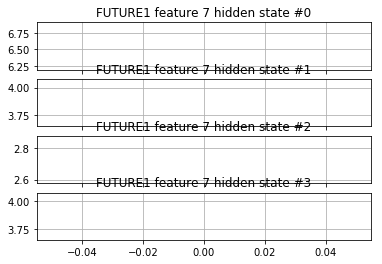

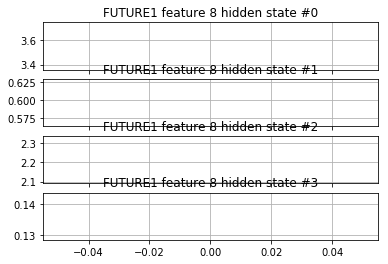

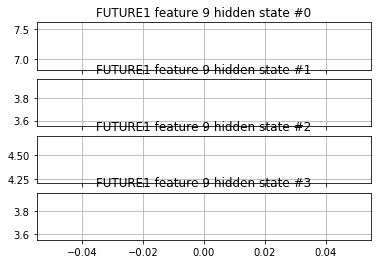

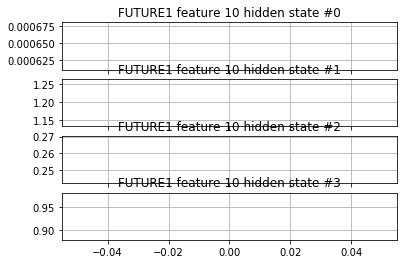

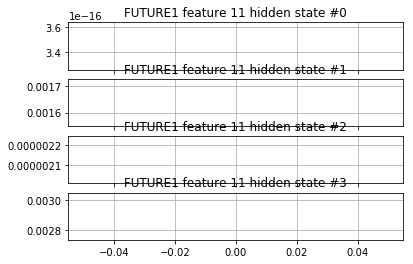

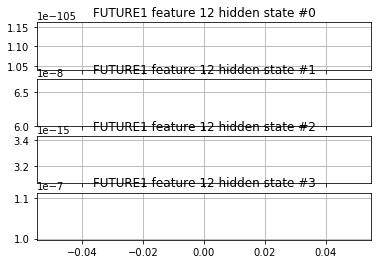

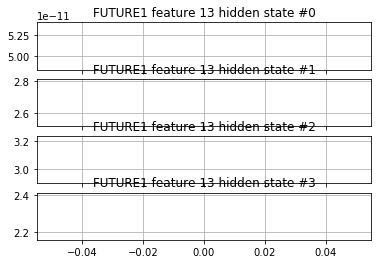

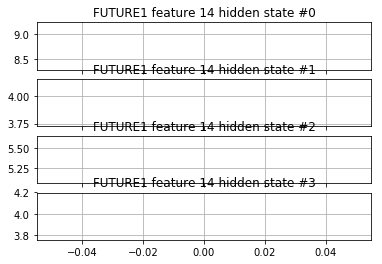

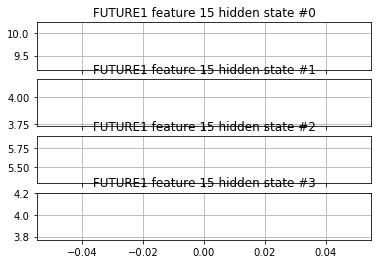

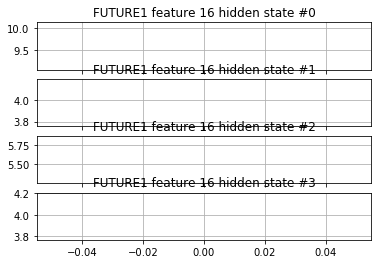

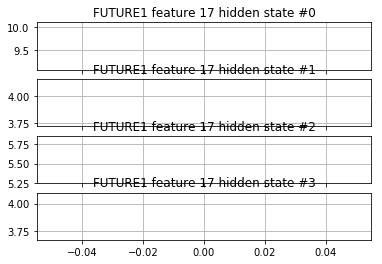

In [32]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [33]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [34]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
    
    

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [35]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [36]:
# TODO: Implement SelectorCV in my_model_selector.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 7 states with time 0.3083498827903513 seconds
Training complete for BOOK with 15 states with time 2.910612832975545 seconds
Training complete for VEGETABLE with 15 states with time 1.326159472824569 seconds
Training complete for FUTURE with 15 states with time 2.8371819048613087 seconds
Training complete for JOHN with 15 states with time 27.876576547350723 seconds


In [37]:
# TODO: Implement SelectorCV in my_model_selector.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorCV

training = asl.build_training(features_norm+features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.3036981689342255 seconds
Training complete for BOOK with 15 states with time 2.8749735537796255 seconds
Training complete for VEGETABLE with 5 states with time 1.235572352627564 seconds
Training complete for FUTURE with 15 states with time 2.2185272346703613 seconds
Training complete for JOHN with 15 states with time 39.56817800351487 seconds


In [98]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.27642083200044 seconds
Training complete for BOOK with 8 states with time 1.5051883958221879 seconds
Training complete for VEGETABLE with 9 states with time 0.5296673700213432 seconds
Training complete for FUTURE with 9 states with time 1.5538998654519673 seconds
Training complete for JOHN with 13 states with time 14.450831187074073 seconds


In [99]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_norm+features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.2771243014722131 seconds
Training complete for BOOK with 4 states with time 1.3079531894763932 seconds
Training complete for VEGETABLE with 3 states with time 0.5256203930475749 seconds
Training complete for FUTURE with 6 states with time 1.2543082656047773 seconds
Training complete for JOHN with 8 states with time 26.099090814183 seconds


In [40]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.6576117158871853 seconds
Training complete for BOOK with 15 states with time 3.456917343924971 seconds
Training complete for VEGETABLE with 15 states with time 2.3486324130518597 seconds
Training complete for FUTURE with 15 states with time 3.3170492788292165 seconds
Training complete for JOHN with 15 states with time 17.014176937203274 seconds


In [41]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_norm+features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.919399677849782 seconds
Training complete for BOOK with 15 states with time 2.898894689034762 seconds
Training complete for VEGETABLE with 7 states with time 2.3590116730090642 seconds
Training complete for FUTURE with 15 states with time 2.977831014998884 seconds
Training complete for JOHN with 15 states with time 24.78913723261107 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

Selector CV shows itself to us as the slowest algorithym, in contrast with with the SelectorDIC and SelectorBIC nearly matched runtimes.BIC does come out slightly faster on our test words, even when the tested with different feature sets, but this is expected as it is slightly less complex. Our DIC selector could be further opimized by using a cache to prevent re-scoring words we have already seen, but it is unlikely this would speed it enough to beat the BIC selector. We can see the some signs that the BIC and DIC selectors are overfitting, as they have tended to select models with more states, but we also saw this with CV which is designed to prevent overfitting.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [94]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 33.266s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [81]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_norm+features_custom, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [44]:
test_set = asl.build_test(features_norm+features_custom)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [79]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [73]:
# TODO Choose a feature set and model selector
features = features_norm+features_custom # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5168539325842697
Total correct: 86 out of 178
Video  Recognized                                                    Correct
    2: *MARY WRITE *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *CAR GO CAN                                              JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *JOHN *VISIT *JOHN *CAR *CAR *FUTURE *FUTURE             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY *LIKE *LOVE                                  JOHN LIKE IX IX IX
   28: JOHN LIKE *MARY *MARY *LOVE                                   JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY IX                                      JOHN LIKE IX IX IX
   36: MARY *WHO *GIVE3 *WOMAN LIKE *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *MARY *CORN *VEGETABLE *MARY                            JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

0.5168539325842697

In [74]:
#set up a function of the above for the above, for better re-use!
def recognize_and_display_result(features = features_norm+features_custom, model_selector = SelectorCV):
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

In [91]:
# feature sets I may use
features_ground
features_norm
features_polar
features_delta

features_custom=features_hand_dist+features_delta_norm_hand_pos+features_norm_polar_coords
features_best=features_norm+features_custom
feature_sets=[features_ground, features_norm,features_polar,features_delta,features_hand_dist,features_delta_norm_hand_pos,features_norm_polar_coords,features_custom, features_best]

# selectors I may use
selector_sets=[SelectorConstant,SelectorBIC,SelectorDIC,SelectorCV]



In [76]:
feature_model_scores=[]
for chosen_feature in feature_sets:
    for model_selector in selector_sets:
        print("----running:", chosen_feature,model_selector)
        recognize_and_display_result(chosen_feature, model_selector )
        

----running: ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'] <class 'my_model_selectors.SelectorConstant'>

**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *

   89: *MARY IX *IX *IX IX *ARRIVE *BOOK                             JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *SOMETHING-ONE IX *IX *VISIT *ARRIVE                     JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX IX *IX *IX BOOK                                      JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *IX NEW CAR *ARRIVE                                           POSS NEW CAR BREAK-DOWN
  105: JOHN *FRANK                                                   JOHN LEG
  107: JOHN *IX *HAVE *ARRIVE *JOHN                                  JOHN POSS FRIEND HAVE CANDY
  108: *IX ARRIVE                                                    WOMAN ARRIVE
  113: IX CAR *IX *MARY *BOX                                         IX CAR BLUE SUE BUY
  119: *VISIT *BUY1 IX *BOX *IX                                      SUE BUY IX CAR BLUE
  122: JOHN *BUY BOOK                                                JOHN READ BOOK
  139: JOHN *BUY1 WHAT *MARY BOOK                                    JOHN BU

  107: *TELL *IX *BOX *LIKE *JANA                                    JOHN POSS FRIEND HAVE CANDY
  108: *LOVE *HOMEWORK                                               WOMAN ARRIVE
  113: IX CAR *IX SUE *HAVE                                          IX CAR BLUE SUE BUY
  119: *VEGETABLE *BUY1 IX CAR *GO                                   SUE BUY IX CAR BLUE
  122: JOHN *HOUSE *COAT                                             JOHN READ BOOK
  139: JOHN *BUY1 *CAR YESTERDAY BOOK                                JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE *MARY *CORN                                              LOVE JOHN WHO
  167: JOHN *JOHN *SAY-1P LOVE MARY                                  JOHN IX SAY LOVE MARY
  171: *SHOOT *JOHN BLAME                                            JOHN MARY BLAME
  174: *NEW *GIVE1 GIVE1 *WHO *CAR                                   PEOPLE GROUP GIVE1 JANA TOY
  181: 

   90: *SELF *GIVE1 *SOMETHING-ONE SOMETHING-ONE WOMAN *BORROW       JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX IX *IX WOMAN BOOK                                    JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS *WRITE CAR BREAK-DOWN                                    POSS NEW CAR BREAK-DOWN
  105: JOHN *POSS                                                    JOHN LEG
  107: *MARY *IX FRIEND *JOHN *JOHN                                  JOHN POSS FRIEND HAVE CANDY
  108: *TOMORROW *LOVE                                               WOMAN ARRIVE
  113: *HIT CAR *IX *JOHN *HOMEWORK                                  IX CAR BLUE SUE BUY
  119: *MARY *BUY1 *HOMEWORK *JOHN *IX                               SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                              JOHN READ BOOK
  139: JOHN *HOMEWORK *CAR *GO *LOVE                                 JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN *ARRIVE *POSS WHAT *BREAK-DOWN                           JOHN BU

   84: *HOMEWORK *GIVE1 *GIVE1 *COAT                                 IX-1P FIND SOMETHING-ONE BOOK
   89: *GIVE *GIVE *WOMAN *WOMAN IX *ARRIVE *BOOK                    JOHN IX GIVE MAN IX NEW COAT
   90: JOHN GIVE IX SOMETHING-ONE WOMAN *ARRIVE                      JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *WOMAN IX *WOMAN WOMAN BOOK                              JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *SEE                                                     JOHN LEG
  107: JOHN POSS *HAVE HAVE *MARY                                    JOHN POSS FRIEND HAVE CANDY
  108: *LOVE *LOVE                                                   WOMAN ARRIVE
  113: IX CAR *IX *MARY *JOHN                                        IX CAR BLUE SUE BUY
  119: *MARY *BUY1 IX *BLAME *IX                                     SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                      

   89: *GIVE1 *JOHN *IX *JOHN IX *WHAT *HOUSE                        JOHN IX GIVE MAN IX NEW COAT
   90: *MARY *JOHN *JOHN *IX *IX *MARY                               JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *MARY *JOHN *JOHN WOMAN *ARRIVE                          JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *JOHN NEW *WHAT BREAK-DOWN                                    POSS NEW CAR BREAK-DOWN
  105: JOHN *MARY                                                    JOHN LEG
  107: JOHN POSS FRIEND *LOVE *MARY                                  JOHN POSS FRIEND HAVE CANDY
  108: *JOHN ARRIVE                                                  WOMAN ARRIVE
  113: *JOHN CAR *MARY *MARY *GIVE1                                  IX CAR BLUE SUE BUY
  119: *JOHN *BUY1 IX CAR *IX                                        SUE BUY IX CAR BLUE
  122: JOHN *VISIT *YESTERDAY                                        JOHN READ BOOK
  139: JOHN *BUY1 WHAT *MARY *ARRIVE                                 JOHN BU

   77: *JOHN *GIVE1 *IX                                              ANN BLAME MARY
   84: *JOHN *BORROW *IX BOOK                                        IX-1P FIND SOMETHING-ONE BOOK
   89: *WOMAN IX *IX *IX IX *IX *TOY                                 JOHN IX GIVE MAN IX NEW COAT
   90: *IX *IX *JOHN *IX *IX *IX                                     JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX IX *IX *POSS *GROUP                                  JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *JOHN NEW CAR *HOMEWORK                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *IX                                                      JOHN LEG
  107: JOHN *JOHN *TOY *PUTASIDE *MARY                               JOHN POSS FRIEND HAVE CANDY
  108: *JOHN *POTATO                                                 WOMAN ARRIVE
  113: *JOHN CAR *MARY *MARY *GIVE1                                  IX CAR BLUE SUE BUY
  119: *JOHN *GIVE1 *WHAT CAR *WHAT                               

   77: *SOMETHING-ONE *LOVE MARY                                     ANN BLAME MARY
   84: *BROTHER *IX *WRITE *PAST                                     IX-1P FIND SOMETHING-ONE BOOK
   89: *YESTERDAY *YESTERDAY *PEOPLE *BREAK-DOWN *HOUSE *POSS *APPLE  JOHN IX GIVE MAN IX NEW COAT
   90: *VEGETABLE *POSS *LOVE *TEACHER WOMAN BOOK                    JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *POSS IX *HOUSE *CAN BOOK                                JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *IX NEW CAR *WOMAN                                            POSS NEW CAR BREAK-DOWN
  105: *YESTERDAY *APPLE                                             JOHN LEG
  107: JOHN *IX *ARRIVE *JOHN *SUE                                   JOHN POSS FRIEND HAVE CANDY
  108: *SOMETHING-ONE *HOMEWORK                                      WOMAN ARRIVE
  113: *JOHN *POSS *MARY *MAN *BUY1                                  IX CAR BLUE SUE BUY
  119: *JANA *ARRIVE *CAR *POSS *BOX                             

  113: *JOHN CAR *MARY *MARY *BUY1                                   IX CAR BLUE SUE BUY
  119: *JOHN *BUY1 IX CAR *MARY                                      SUE BUY IX CAR BLUE
  122: JOHN READ *YESTERDAY                                          JOHN READ BOOK
  139: JOHN *BUY1 WHAT *JOHN *STOLEN                                 JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT *YESTERDAY                            JOHN BUY YESTERDAY WHAT BOOK
  158: LOVE *IX WHO                                                  LOVE JOHN WHO
  167: JOHN IX *LIKE LOVE *HERE                                      JOHN IX SAY LOVE MARY
  171: JOHN *JOHN BLAME                                              JOHN MARY BLAME
  174: *CAR *LOVE GIVE1 *WHAT *FINISH                                PEOPLE GROUP GIVE1 JANA TOY
  181: JOHN *GIVE1                                                   JOHN ARRIVE
  184: *IX *WHO *GIVE1 TEACHER *MARY                                 ALL BOY GIVE TEACHER APPLE
  189: JO

   71: JOHN *JOHN VISIT *GROUP                                       JOHN WILL VISIT MARY
   74: JOHN *JOHN *JOHN MARY                                         JOHN NOT VISIT MARY
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
   84: *ANN *CAR *WRITE BOOK                                         IX-1P FIND SOMETHING-ONE BOOK
   89: JOHN *JOHN GIVE *IX *JOHN NEW *DECIDE                         JOHN IX GIVE MAN IX NEW COAT
   90: *MARY *JOHN *JOHN *IX WOMAN BOOK                              JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX *JOHN *JOHN WOMAN *BORROW                            JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: *JOHN *BLAME CAR *HOMEWORK                                    POSS NEW CAR BREAK-DOWN
  105: JOHN *JOHN                                                    JOHN LEG
  107: JOHN *JOHN *TOY *PUTASIDE *JOHN                               JOHN POSS FRIEND HAVE CANDY
  108: *JOHN *HOMEWORK                                    

   89: *FRANK *GIVE GIVE *THINK *GIVE NEW COAT                       JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *GIVE1 IX SOMETHING-ONE WOMAN *ARRIVE                    JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN GIVE *SOMETHING-ONE SOMETHING-ONE WOMAN BOOK             JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: *FRANK *VEGETABLE                                             JOHN LEG
  107: JOHN *SUE FRIEND *GO *JOHN                                    JOHN POSS FRIEND HAVE CANDY
  108: *GIVE1 *BOOK                                                  WOMAN ARRIVE
  113: IX CAR BLUE *SOMETHING-ONE *BUY1                              IX CAR BLUE SUE BUY
  119: *PREFER *BUY1 *BLUE CAR *JANA                                 SUE BUY IX CAR BLUE
  122: *SOMETHING-ONE READ BOOK                                      JOHN READ BOOK
  139: JOHN *BUY1 WHAT YESTERDAY BOOK                                JOHN BU

   89: JOHN *GIVE GIVE *SELF *GIVE NEW COAT                          JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *GIVE1 *GIVE1 SOMETHING-ONE WOMAN *ARRIVE                JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN GIVE IX *IX WOMAN BOOK                                   JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *VEGETABLE                                               JOHN LEG
  107: JOHN *SUE FRIEND *GO *MARY                                    JOHN POSS FRIEND HAVE CANDY
  108: *FRANK *BOOK                                                  WOMAN ARRIVE
  113: *JOHN CAR BLUE *JOHN *BUY1                                    IX CAR BLUE SUE BUY
  119: *JOHN *BUY1 *BLUE *TOY *JANA                                  SUE BUY IX CAR BLUE
  122: JOHN *HOUSE BOOK                                              JOHN READ BOOK
  139: JOHN *BUY1 WHAT YESTERDAY *ARRIVE                             JOHN BU

   77: *IX BLAME *IX                                                 ANN BLAME MARY
   84: *ARRIVE *GIVE1 *YESTERDAY BOOK                                IX-1P FIND SOMETHING-ONE BOOK
   89: *THINK IX *IX *SEARCH-FOR IX *BOOK COAT                       JOHN IX GIVE MAN IX NEW COAT
   90: *MARY *IX IX *IX WOMAN BOOK                                   JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *IX IX *IX *IX BOOK                                      JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *WHO                                                     JOHN LEG
  107: *MARY POSS *ARRIVE *IX *MARY                                  JOHN POSS FRIEND HAVE CANDY
  108: *IX *BOOK                                                     WOMAN ARRIVE
  113: *JOHN CAR *CAR *MARY *BUY1                                    IX CAR BLUE SUE BUY
  119: *MARY *BUY1 IX CAR *IX                                     

   89: JOHN IX *IX *SEARCH-FOR IX *WRITE COAT                        JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *GIVE1 *GIVE1 SOMETHING-ONE WOMAN *FRIEND                JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *SEARCH-FOR IX *IX WOMAN BOOK                            JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS *WRITE CAR BREAK-DOWN                                    POSS NEW CAR BREAK-DOWN
  105: JOHN *VEGETABLE                                               JOHN LEG
  107: *MARY *JOHN FRIEND *MARY *MARY                                JOHN POSS FRIEND HAVE CANDY
  108: WOMAN *BOOK                                                   WOMAN ARRIVE
  113: *JOHN CAR *MARY *MARY *BUY1                                   IX CAR BLUE SUE BUY
  119: *MARY *BUY1 *WHAT CAR *OLD                                    SUE BUY IX CAR BLUE
  122: JOHN *CAR BOOK                                                JOHN READ BOOK
  139: JOHN *BUY1 WHAT *WHAT *FRIEND                                 JOHN BU

   89: *SOMETHING-ONE IX *SOMETHING-ONE *CANDY IX *BOOK COAT         JOHN IX GIVE MAN IX NEW COAT
   90: *PREFER *GIVE1 IX *IX WOMAN BOOK                              JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *GIVE1 IX *IX WOMAN BOOK                                 JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *WHO                                                     JOHN LEG
  107: *SHOULD POSS *CAR *MARY *MARY                                 JOHN POSS FRIEND HAVE CANDY
  108: *SOMETHING-ONE ARRIVE                                         WOMAN ARRIVE
  113: *JOHN CAR *CAR *MARY *ARRIVE                                  IX CAR BLUE SUE BUY
  119: *PREFER *BUY1 *GO CAR *VISIT                                  SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                              JOHN READ BOOK
  139: JOHN *BUY1 WHAT YESTERDAY BOOK                                JOHN BU

In [97]:
# run a test for a specific combination of features/selectors
recognize_and_display_result(features_norm_polar_coords+features_delta_norm_hand_pos, selector_sets[2] )


**** WER = 0.39325842696629215
Total correct: 108 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *WHAT                                            JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE WONT *WHO BUT *CAR *FUTURE *MARY              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *LOVE IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX IX                                            JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   36: MARY *JOHN *GIRL *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *POSS BUY HOUSE       

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
    The best combination from my original feature sets seems to have come from the combination of normalized polar coordinates with their deltas(features_delta_norm_hand_pos), and the DIC selector, with a WER = 0.4044, and Total correct: 106 out of 178. This can be attributed to several factors:
    - The selector policy not overfitting the data, as opposed to what we anticipated with the last question. This may change as more data is used.
    - The normalized polar coordinates/w deltas seem to better indicate hand position correctly.
    
The worst combination observed was using distance between hands, and the rate of change of that distance (features_hand_dist) with SelectorBIC, with a WER = 0.9213, and Total correct: 14 out of 178. The data set simply did not have enough features to be of use!

After observing the scores, I suspected that the hand distance should still be able to add value, so I combined the two data sets(features_delta_norm_hand_pos and features_hand_dist) and again used SelectorBIC to achieve the highest score observed in these tests: WER = 0.3932, and Total correct: 108 out of 178. This validates the idea that normalized data/polar coordinates/hand-distance features are the most valuable, and the original data needs to be greatly transformed to be most useful.
    
We can anticipate two methods to improve the score:
    - Add more features: one method, mentioned in [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf), is to use PCA on each image frame, to assist in capturing more information about hand orientation. Other tactics to be tried include using different combinations of the tested feature sets
    - Improve our guess. This can be done in various ways, with the first and most obvious being to use a words probability of appearing in the same phrase as a modifier on probability, and calculating the guess based in that information, as outlined below! 
    - Improve our probabilities: First, we can optimize the hyperparameters of the model using a gridsearch or similar. Also, we can use ensemble methods, such as stacking to combine multiple models, for an improved probability set. This would require a bit or rework of the base_model method, to convert everything over to a format that works for scikit learn and build a proper pipeline that can be returned as a model.
   

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [87]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 23.933s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [93]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2067.010836,-767.519589,-1539.325400,-83.791391,-1045.751728,-337.658776,-2288.001480,-484.860590,-6988.128116,-481.398354,...,-3382.885217,139.204051,-5543.106028,-145.273186,101.203498,-455.663959,-572.564026,-1553.495974,-1217.665347,44.366393
1,-7456.930610,-4643.414672,-3527.246300,158.675871,-6698.850106,-139.137972,-3973.259713,159.872587,-4114.707367,-186.507139,...,-307.974705,58.662513,-2657.202190,-27.786399,-141.161533,-3815.644094,-276.643200,-3627.993935,216.015217,-87.336730
2,-10634.334063,-5419.519485,-5415.645160,193.809785,-9780.359478,-330.496706,-5498.605684,-303.597229,-9745.811191,-316.318320,...,-1498.171596,164.038320,-6604.477823,-213.677483,-222.956822,-4541.494340,-888.575092,-3734.703284,-781.495062,-112.693119
3,-1266.006788,-2052.018577,-886.241616,-51.800291,-1655.268607,-351.466072,-803.728899,-588.010285,-10637.493273,-449.147831,...,-4325.075817,209.075693,-5102.437325,51.463306,175.907820,-539.551875,-295.906472,-509.467792,-1950.171108,-156.412967
4,-2259.790386,-2052.046270,-760.550551,31.038891,-3682.778663,-23.609359,-1439.230148,-78.600453,-2097.692578,-124.394964,...,-432.714364,28.821075,-537.418615,-8.271928,-225.765319,-1648.414167,-175.986371,-760.750882,-303.957270,-110.549636


###  EOF - Submited for review 7-13-2017